In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from fdm import LinearPoissonFDM, NonLinearPoissonFDM
from pinn import LinearPoissonPINN, NonLinearPoissonPINN
from pinn import getBC, getCollocationPoints
from pinn import getSupervisedDataLoader, getUnsupervisedDataLoader

### Problema lineal

1) Resolver las ecuaciones:
$$ 
\begin{align}
\Delta u &= \sin{\pi x}\sin{\pi y}\,,\quad 0< x <1 \quad 0< y <1\,, \tag{1a}\\
u(0, y) &= u(1, y) = 0\,, \tag{1b}\\
u(x, 0) &= u(x, 1) = 0\,, \tag{1c}
\end{align} 
$$
mediante PINN y mediante el método de diferencias finitas en grillas de tamaño:
- 5 x 5 usar una red neuronal [2, 3, 3, 1]
- 10 x 10 usar una red neuronal [2, 5, 5, 1]
- 20 x 20 usar una red neuronal [2, 10, 10, 1]
Comparar ambas soluciones con la solución exacta dada por:
$$
\begin{equation}
u(x, y) = -\dfrac{1}{2\pi^2}\sin{\pi x}\sin{\pi y}
\end{equation}
$$
¿Qué solución es más precisa? ¿Por qué? Repita el experimento utilizando otras arquitecturas.


In [2]:
# Define the model's parameters
nb = [10, 20, 25, 50, 100]
nf = [50, 100, 400, 1000, 2000]
hidden_neurons = [3, 5, 10, 20, 40]
bc_batch_size = [4, 8, 8, 8, 16]
domain_batch_size = [8, 16, 16, 16, 32]
parameters = {
    'num_hidden_layers': 2,
    'activations': nn.Tanh(),
    'init_type': 'xavier',
    'device': 'cpu',
    'epochs': 2500,
    'lr': 1e-4,
    'epch_print': 500,
}

In [3]:
# Build the dataloaders
dataloaders = []
for nb_i, nf_i, bc_bs, nf_bs in zip(nb, nf, bc_batch_size, domain_batch_size):
    bc_dl = getSupervisedDataLoader(getBC, n=nb_i, batch_size=bc_bs)
    domain_dl = getUnsupervisedDataLoader(getCollocationPoints, n=nf_i, batch_size=nf_bs)
    train_dl = (bc_dl[0], domain_dl[0])
    val_dl = (bc_dl[1], domain_dl[1])
    dataloaders.append((train_dl, val_dl))

In [4]:
# Build the models
models = []
for hn in hidden_neurons:
    sizes = [2] + [hn] * parameters['num_hidden_layers'] + [1]
    activations = [parameters['activations']] * parameters['num_hidden_layers']
    model = LinearPoissonPINN(
        sizes=sizes, 
        activations=activations, 
        init_type=parameters['init_type'], 
        device=parameters['device']
    )
    model.to(parameters['device'])
    models.append(model)

In [6]:
for i, (model, dataloader) in enumerate(zip(models, dataloaders)):
    model.fit(
        train_dataloader=dataloader[0], 
        eval_dataloader=dataloader[1], 
        epochs=parameters['epochs'], 
        lr=parameters['lr'], 
        epch_print=parameters['epch_print'],
    )
    hn = hidden_neurons[i]
    model.save(f"models/model_2hl_{hn}n.pth")
    print('-' * 50)

Epoch 500/2500: Loss (0.05661, 0.06386)
Epoch 1000/2500: Loss (0.024, 0.04068)
Epoch 1500/2500: Loss (0.01416, 0.02129)
Epoch 2000/2500: Loss (0.01184, 0.01638)
Epoch 2500/2500: Loss (0.0118, 0.01609)
--------------------------------------------------
Epoch 500/2500: Loss (0.03132, 0.03621)
Epoch 1000/2500: Loss (0.01381, 0.01932)
Epoch 1500/2500: Loss (0.005544, 0.006309)
Epoch 2000/2500: Loss (0.001887, 0.001561)
Epoch 2500/2500: Loss (0.0006713, 0.000684)
--------------------------------------------------
Epoch 500/2500: Loss (0.008458, 0.0248)
Epoch 1000/2500: Loss (0.0008426, 0.003633)
Epoch 1500/2500: Loss (0.0002308, 0.001158)
Epoch 2000/2500: Loss (0.0001929, 0.0006607)
Epoch 2500/2500: Loss (0.0001839, 0.0005768)
--------------------------------------------------
Epoch 500/2500: Loss (0.0001798, 0.0004948)
Epoch 1000/2500: Loss (4.343e-05, 0.0001089)
Epoch 1500/2500: Loss (1.76e-05, 5.046e-05)
Epoch 2000/2500: Loss (1.312e-05, 2.86e-05)
Epoch 2500/2500: Loss (9.793e-06, 2.272e

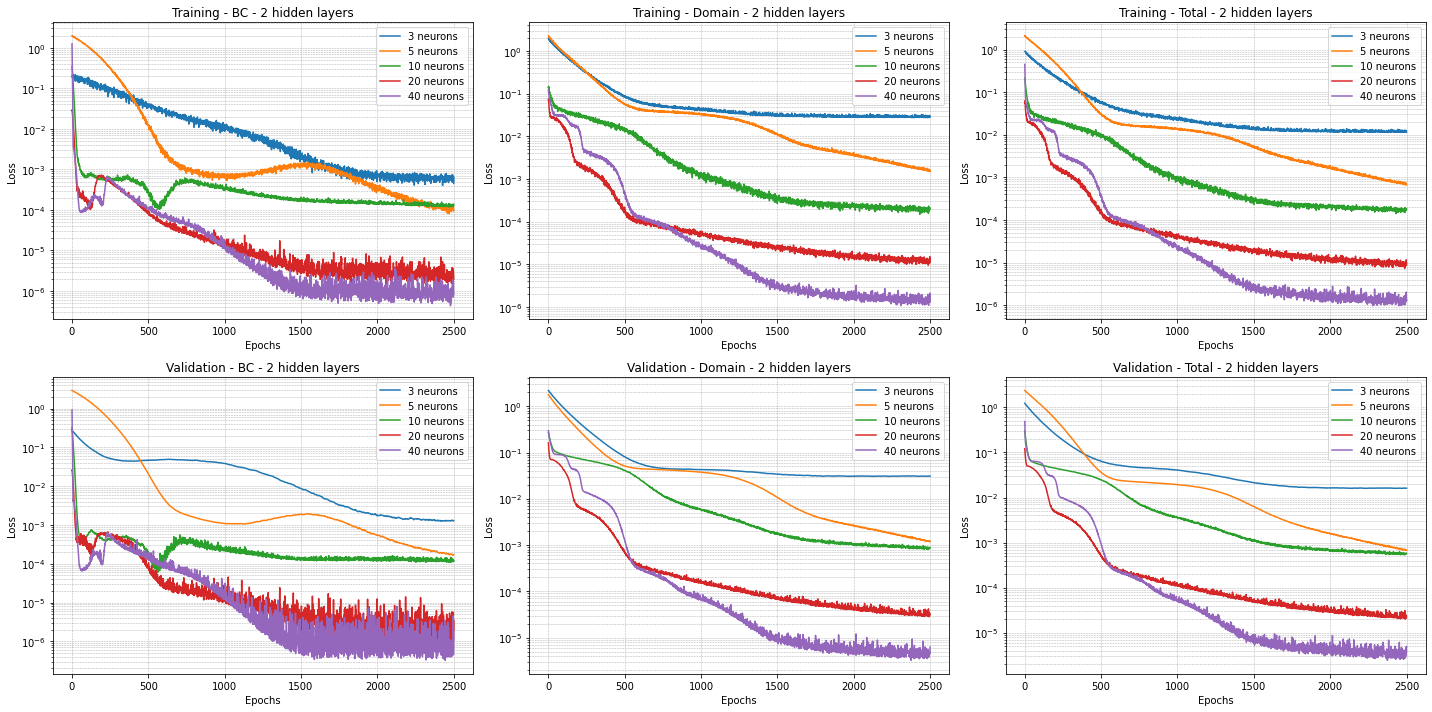

In [ ]:
# Plot the results
labels = ['3 neurons', '5 neurons', '10 neurons', '20 neurons', '40 neurons']

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Plot training loss: BC / Domain / Total
for model, label in zip(models, labels):
    axs[0][0].plot(model.metrics['epochs'], model.metrics['loss']['train']['bc'], label=f"{label}")
    axs[0][1].plot(model.metrics['epochs'], model.metrics['loss']['train']['domain'], label=f"{label}")
    axs[0][2].plot(model.metrics['epochs'], model.metrics['loss']['train']['total'], label=f"{label}")

axs[0][0].set_title("Training - BC - 2 hidden layers")
axs[0][1].set_title("Training - Domain - 2 hidden layers")
axs[0][2].set_title("Training - Total - 2 hidden layers")
for i in range(3):
    axs[0][i].set_xlabel("Epochs")
    axs[0][i].set_ylabel("Loss")
    axs[0][i].legend(loc='best')
    axs[0][i].set_yscale('log')
    axs[0][i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot validation loss: BC / Domain / Total
for model, label in zip(models, labels):
    axs[1][0].plot(model.metrics['epochs'], model.metrics['loss']['eval']['bc'], label=f"{label}")
    axs[1][1].plot(model.metrics['epochs'], model.metrics['loss']['eval']['domain'], label=f"{label}")
    axs[1][2].plot(model.metrics['epochs'], model.metrics['loss']['eval']['total'], label=f"{label}")

axs[1][0].set_title("Validation - BC - 2 hidden layers")
axs[1][1].set_title("Validation - Domain - 2 hidden layers")
axs[1][2].set_title("Validation - Total - 2 hidden layers")
for i in range(3):
    axs[1][i].set_xlabel("Epochs")
    axs[1][i].set_ylabel("Loss")
    axs[1][i].legend(loc='best')
    axs[1][i].set_yscale('log')
    axs[1][i].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("figures/loss_2hl.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()

In [11]:
models_fdm = [
    LinearPoissonFDM(nx=5, ny=5),
    LinearPoissonFDM(nx=10, ny=10),
    LinearPoissonFDM(nx=20, ny=20),
    LinearPoissonFDM(nx=30, ny=30),
    LinearPoissonFDM(nx=40, ny=40)
]

# Solve the equations
for model in models_fdm:
    model.solve()

# Compute the errors
errors = [model.error() for model in models_fdm]

In [13]:
# Predict the solutions
errors_pinn = []
for model_fdm, model_pinn in zip(models_fdm, models):
    x, y = np.meshgrid(model_fdm.mesh.x, model_fdm.mesh.y, indexing='ij')
    xy = np.concatenate((x.flatten()[:, None], y.flatten()[:, None]), axis=1)
    xy = torch.tensor(xy, dtype=torch.float32)
    u_pred = model_pinn.forward(xy).detach().numpy().reshape(model_fdm.u.shape)
    u_exact = model_fdm.exact(x, y)
    error = np.linalg.norm(u_pred - u_exact, 2) / np.linalg.norm(u_exact, 2)
    errors_pinn.append(error)

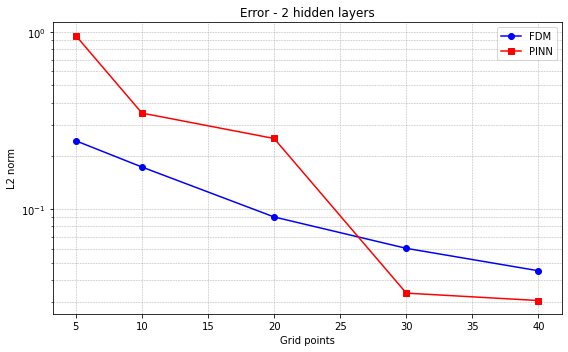

In [14]:
# Plot L2 norm of the error
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot([5, 10, 20, 30, 40], errors, 'bo-', label="FDM")
ax.plot([5, 10, 20, 30, 40], errors_pinn, 'rs-', label="PINN")
ax.set_title("Error - 2 hidden layers")
ax.set_xlabel("Grid points")
ax.set_ylabel("L2 norm")
ax.legend(loc='best')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.tight_layout()
plt.savefig("figures/error_2hl.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()


In [15]:
# Define the parameters
hidden_neurons = [10, 20, 40]
parameters = {
    'num_hidden_layers': 4,
    'activations': nn.Tanh(),
    'init_type': 'xavier',
    'device': 'cpu',
    'nb': 100,
    'nf': 5000,
    'bc_batch_size': 16,
    'domain_batch_size': 32,
    'epochs': 5000,
    'lr': 1e-4,
    'epch_print': 1000,
}

# Build the dataloader
bc_dl = getSupervisedDataLoader(getBC, n=parameters['nb'], batch_size=parameters['bc_batch_size'])
domain_dl = getUnsupervisedDataLoader(getCollocationPoints, n=parameters['nf'], batch_size=parameters['domain_batch_size'])
train_dl = (bc_dl[0], domain_dl[0])
val_dl = (bc_dl[1], domain_dl[1])
dataloader = (train_dl, val_dl)

# Build the models
models = []
for hn in hidden_neurons:
    layers = [2] + [hn] * parameters['num_hidden_layers'] + [1]
    activations = [parameters['activations']] * parameters['num_hidden_layers']
    model = LinearPoissonPINN(
        sizes=layers, 
        activations=activations, 
        init_type=parameters['init_type'], 
        device=parameters['device']
    )
    model.to(parameters['device'])
    models.append(model)

In [16]:
for hn, model in zip(hidden_neurons, models):
    model.fit(
        train_dataloader=dataloader[0], 
        eval_dataloader=dataloader[1], 
        epochs=parameters['epochs'], 
        lr=parameters['lr'], 
        epch_print=parameters['epch_print'],
    )
    print('-' * 80)
    model.save(f"models/model_4hl_{hn}n.pth")

Epoch 1000/5000: Loss (2.044e-05, 0.0001099)
Epoch 2000/5000: Loss (3.062e-06, 1.345e-05)
Epoch 3000/5000: Loss (9.643e-07, 7.62e-06)
Epoch 4000/5000: Loss (6.764e-07, 4.584e-06)
Epoch 5000/5000: Loss (5.185e-07, 2.517e-06)
--------------------------------------------------------------------------------
Epoch 1000/5000: Loss (3.182e-06, 1.981e-05)
Epoch 2000/5000: Loss (8.32e-07, 9.204e-06)
Epoch 3000/5000: Loss (8.843e-07, 2.541e-06)
Epoch 4000/5000: Loss (4.064e-07, 3.977e-06)
Epoch 5000/5000: Loss (4.172e-07, 1.992e-06)
--------------------------------------------------------------------------------
Epoch 1000/5000: Loss (1.348e-06, 5.756e-06)
Epoch 2000/5000: Loss (3.863e-07, 3.213e-06)
Epoch 3000/5000: Loss (1.463e-06, 8.663e-06)
Epoch 4000/5000: Loss (5.593e-07, 3.052e-06)
Epoch 5000/5000: Loss (3.32e-07, 3.118e-06)
--------------------------------------------------------------------------------


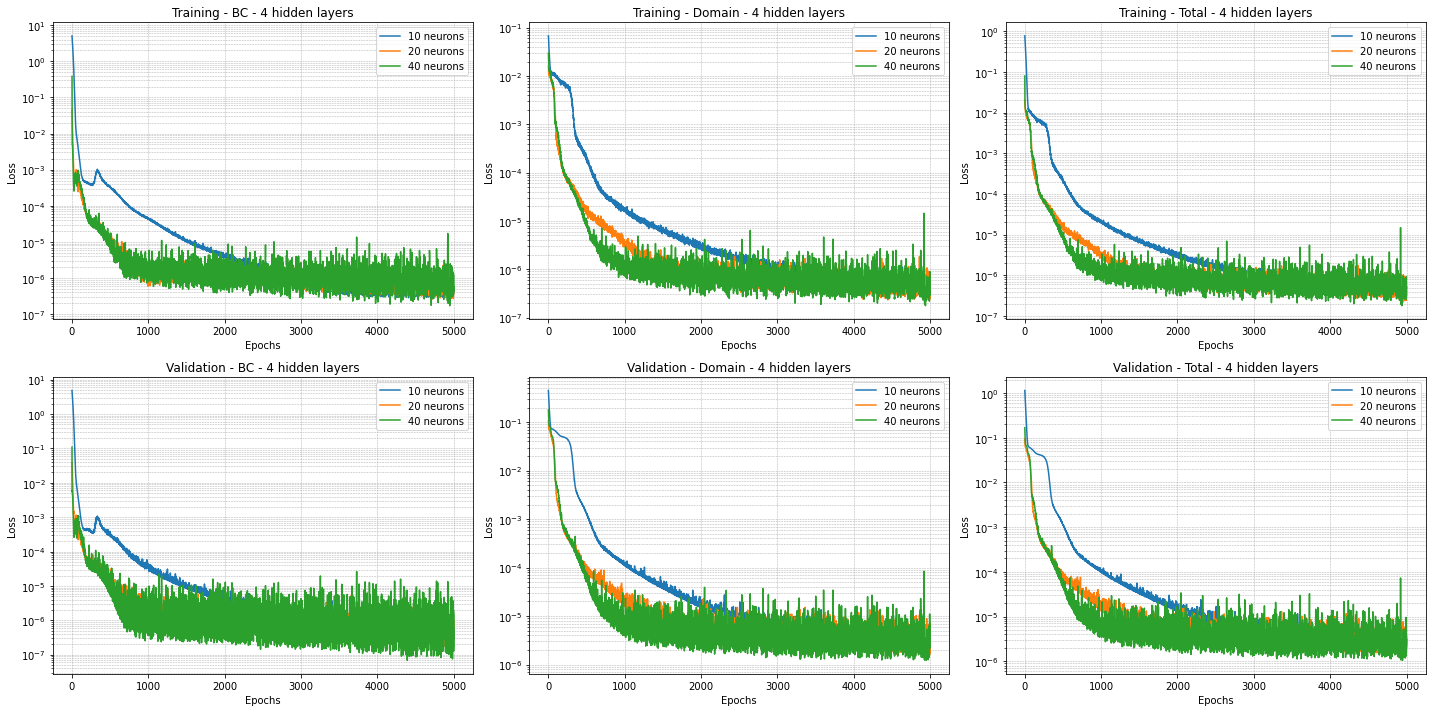

In [17]:
# Plot the results
labels = ['10 neurons', '20 neurons', '40 neurons']

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Plot training loss: BC / Domain / Total
for model, label in zip(models, labels):
    axs[0][0].plot(model.metrics['epochs'], model.metrics['loss']['train']['bc'], label=f"{label}")
    axs[0][1].plot(model.metrics['epochs'], model.metrics['loss']['train']['domain'], label=f"{label}")
    axs[0][2].plot(model.metrics['epochs'], model.metrics['loss']['train']['total'], label=f"{label}")

axs[0][0].set_title("Training - BC - 4 hidden layers")
axs[0][1].set_title("Training - Domain - 4 hidden layers")
axs[0][2].set_title("Training - Total - 4 hidden layers")
for i in range(3):
    axs[0][i].set_xlabel("Epochs")
    axs[0][i].set_ylabel("Loss")
    axs[0][i].legend(loc='best')
    axs[0][i].set_yscale('log')
    axs[0][i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot validation loss: BC / Domain / Total
for model, label in zip(models, labels):
    axs[1][0].plot(model.metrics['epochs'], model.metrics['loss']['eval']['bc'], label=f"{label}")
    axs[1][1].plot(model.metrics['epochs'], model.metrics['loss']['eval']['domain'], label=f"{label}")
    axs[1][2].plot(model.metrics['epochs'], model.metrics['loss']['eval']['total'], label=f"{label}")

axs[1][0].set_title("Validation - BC - 4 hidden layers")
axs[1][1].set_title("Validation - Domain - 4 hidden layers")
axs[1][2].set_title("Validation - Total - 4 hidden layers")
for i in range(3):
    axs[1][i].set_xlabel("Epochs")
    axs[1][i].set_ylabel("Loss")
    axs[1][i].legend(loc='best')
    axs[1][i].set_yscale('log')
    axs[1][i].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("figures/loss_4hl.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()

### Problema No Lineal

In [10]:
# Define the model's parameters
nb = [10, 20, 25, 50, 100]
nf = [50, 100, 400, 1000, 2000]
hidden_neurons = [3, 5, 10, 20, 40]
bc_batch_size = [4, 8, 8, 8, 16]
domain_batch_size = [8, 16, 16, 16, 32]
parameters = {
    'num_hidden_layers': 2,
    'activations': nn.Tanh(),
    'init_type': 'xavier',
    'device': 'cpu',
    'epochs': 5000,
    'lr': 1e-4,
    'epch_print': 1000,
}

In [11]:
# Build the dataloaders
dataloaders = []
for nb_i, nf_i, bc_bs, nf_bs in zip(nb, nf, bc_batch_size, domain_batch_size):
    dirichlet_dl = getSupervisedDataLoader(getBC, n=nb_i, batch_size=bc_bs, active=[1,0,1,0])
    right_dl = getSupervisedDataLoader(getBC, n=nb_i, batch_size=bc_bs, active=[0,0,0,1])
    top_dl = getSupervisedDataLoader(getBC, n=nb_i, batch_size=bc_bs, active=[0,1,0,0])
    domain_dl = getUnsupervisedDataLoader(getCollocationPoints, n=nf_i, batch_size=nf_bs)
    train_dl = (dirichlet_dl[0], right_dl[0], top_dl[0], domain_dl[0])
    val_dl = (dirichlet_dl[1], right_dl[1], top_dl[1], domain_dl[1])
    dataloaders.append((train_dl, val_dl))

In [12]:
# Build the models
models = []
for hn in hidden_neurons:
    layers = [2] + [hn] * parameters['num_hidden_layers'] + [1]
    activations = [parameters['activations']] * parameters['num_hidden_layers']
    model = NonLinearPoissonPINN(
        sizes=layers, 
        activations=activations, 
        init_type=parameters['init_type'], 
        device=parameters['device']
    )
    model.to(parameters['device'])
    models.append(model)

In [13]:
for hn, model, dataloader in zip(hidden_neurons, models, dataloaders):
    model.fit(
        train_dataloader=dataloader[0], 
        eval_dataloader=dataloader[1], 
        epochs=parameters['epochs'], 
        lr=parameters['lr'], 
        epch_print=parameters['epch_print'],
    )
    print('-' * 80)
    model.save(f"models/model_2hl_{hn}n_nonlinear.pth")

Epoch 1000/5000: Loss (0.003953, 0.008152)
Epoch 2000/5000: Loss (0.001605, 0.003575)
Epoch 3000/5000: Loss (0.001008, 0.002768)
Epoch 4000/5000: Loss (0.0007764, 0.001817)
Epoch 5000/5000: Loss (0.000814, 0.00148)
--------------------------------------------------------------------------------
Epoch 1000/5000: Loss (0.02045, 0.03814)
Epoch 2000/5000: Loss (0.01451, 0.02619)
Epoch 3000/5000: Loss (0.01586, 0.02525)
Epoch 4000/5000: Loss (0.01348, 0.02093)
Epoch 5000/5000: Loss (0.01199, 0.01677)
--------------------------------------------------------------------------------
Epoch 1000/5000: Loss (0.004113, 0.01096)
Epoch 2000/5000: Loss (0.0009866, 0.002118)
Epoch 3000/5000: Loss (0.0006808, 0.0006296)
Epoch 4000/5000: Loss (0.001293, 0.0008522)
Epoch 5000/5000: Loss (0.001164, 0.0006849)
--------------------------------------------------------------------------------
Epoch 1000/5000: Loss (0.001072, 0.001465)
Epoch 2000/5000: Loss (0.000699, 0.0007638)
Epoch 3000/5000: Loss (0.000507

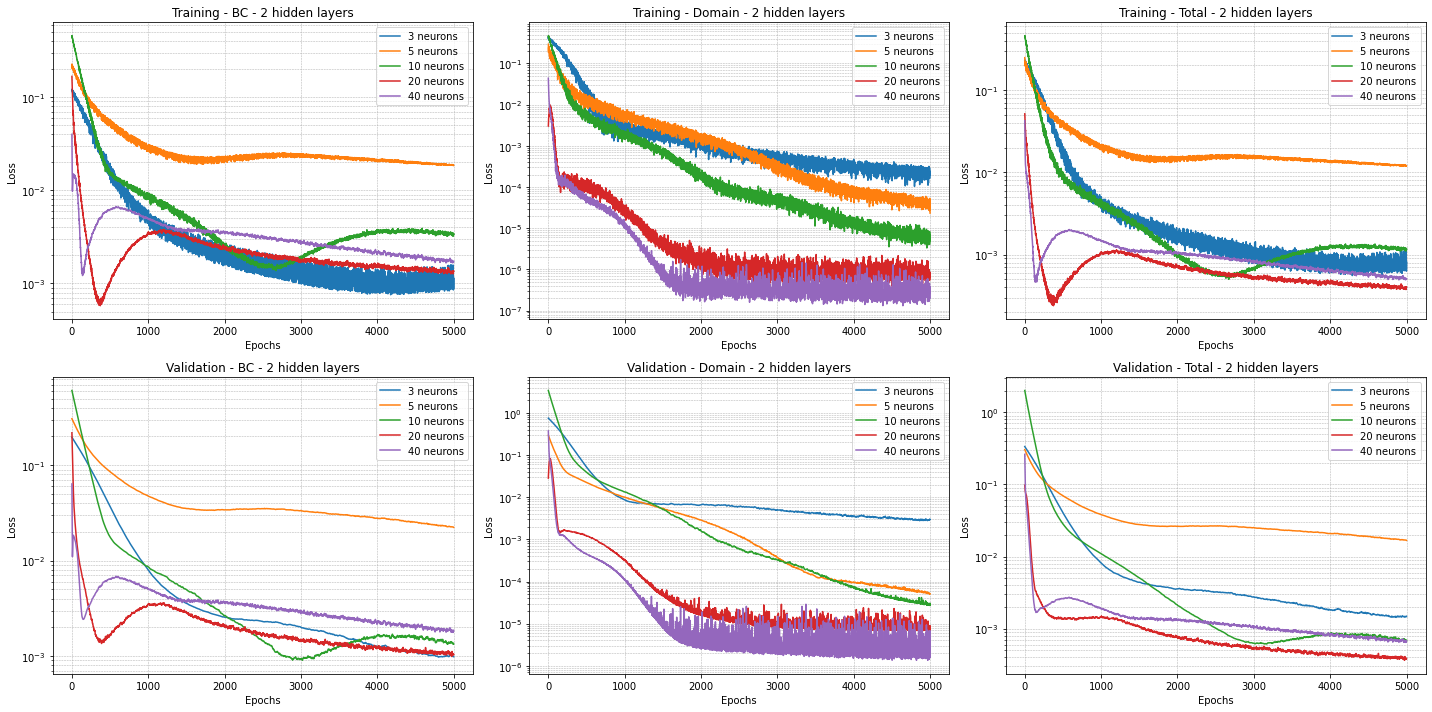

In [14]:
# Plot the results
labels = ['3 neurons', '5 neurons', '10 neurons', '20 neurons', '40 neurons']

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Plot training loss: BC / Domain / Total
for model, label in zip(models, labels):
    axs[0][0].plot(model.metrics['epochs'], model.metrics['loss']['train']['bc'], label=f"{label}")
    axs[0][1].plot(model.metrics['epochs'], model.metrics['loss']['train']['domain'], label=f"{label}")
    axs[0][2].plot(model.metrics['epochs'], model.metrics['loss']['train']['total'], label=f"{label}")

axs[0][0].set_title("Training - BC - 2 hidden layers")
axs[0][1].set_title("Training - Domain - 2 hidden layers")
axs[0][2].set_title("Training - Total - 2 hidden layers")
for i in range(3):
    axs[0][i].set_xlabel("Epochs")
    axs[0][i].set_ylabel("Loss")
    axs[0][i].legend(loc='best')
    axs[0][i].set_yscale('log')
    axs[0][i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot validation loss: BC / Domain / Total
for model, label in zip(models, labels):
    axs[1][0].plot(model.metrics['epochs'], model.metrics['loss']['eval']['bc'], label=f"{label}")
    axs[1][1].plot(model.metrics['epochs'], model.metrics['loss']['eval']['domain'], label=f"{label}")
    axs[1][2].plot(model.metrics['epochs'], model.metrics['loss']['eval']['total'], label=f"{label}")

axs[1][0].set_title("Validation - BC - 2 hidden layers")
axs[1][1].set_title("Validation - Domain - 2 hidden layers")
axs[1][2].set_title("Validation - Total - 2 hidden layers")
for i in range(3):
    axs[1][i].set_xlabel("Epochs")
    axs[1][i].set_ylabel("Loss")
    axs[1][i].legend(loc='best')
    axs[1][i].set_yscale('log')
    axs[1][i].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("figures/loss_2hl_nonlinear.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()

In [7]:
# Predict the non linear solution
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
xy = np.concatenate((x.flatten()[:, None], y.flatten()[:, None]), axis=1)
xy = torch.tensor(xy, dtype=torch.float32, requires_grad=True)

u_pred = models[4].forward(xy).detach().view(-1,1).numpy()

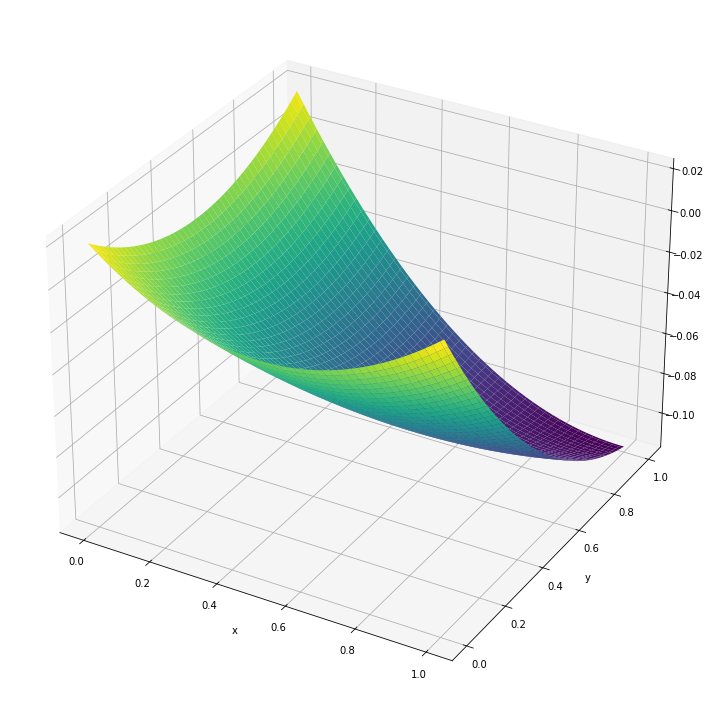

In [9]:
# 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, u_pred.reshape(100, 100), cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()
plt.show()